## Lựa chọn đặc trưng bằng Xáo trộn ngẫu nhiên (Random Shuffling)

Đây là phương pháp lựa chọn đặc trưng phổ biến, xáo trộn ngẫu nhiên các giá trị của một biến cụ thể và xác định xem phép hoán vị đó ảnh hưởng như thế nào đến chỉ số chất lượng của thuật toán học máy. Nói cách khác, ý tưởng ở đây là hoán vị các giá trị của từng đặc trưng, đo mức độ hoán vị (hoặc xáo trộn các giá trị của nó) làm giảm accuracy (độ chính xác), roc_auc hoặc mse của mô hình học máy (hoặc bất kỳ số liệu chất lượng nào khác!). Nếu các biến quan trọng, hoán vị ngẫu nhiên các giá trị sẽ giảm đáng kể bất kỳ số liệu nào trong số này. Ngược lại, hoán vị hoặc xáo trộn các giá trị sẽ ít hoặc không ảnh hưởng đến chỉ số chất lượng của mô hình mà chúng ta đang đánh giá.

Quy trình như sau:

- Xây dựng mô hình học máy và lưu trữ chỉ số chất lượng
- Xáo trộn một đặc trưng và đưa ra dự đoán mới sử dụng mô hình trước đó
- Xác định chất lượng của dự đoán này
- Xác định thay đổi trong chất lượng của dự đoán với đặc trưng đa xáo trộn so với đặc trưng ban đầu
- Lặp lại cho từng đặc trưng

Chúng ta sẽ chọn các đặc trưng làm giảm chất lượng mô hình vượt một ngưỡng thiết lập bất kỳ để lựa chọn đặc trưng.

Chúng ta sẽ minh họa cách lựa chọn đặc trưng dựa trên xáo trộn ngẫu nhiên trong bài toán hồi quy và phân loại.

**Lưu ý** Chúng ta sẽ tiếp tục dùng Random Forest nhưng với quy trình lựa chọn này, có thể sử dụng với cả thuật toán học máy. Trên thực tế, cần xác định rành mạch độ quan trọng của các đặc trưng cho thuật toán được dùng. Do đó, các thuật toán khác nhau sẽ trả về các tập hợp con khác nhau của đặc trưng quan trọng.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score

## Phân loại

In [2]:
# load tập dữ liệu
data = pd.read_csv('dataset_2.csv')
data.shape

(50000, 109)

In [3]:
data.head()

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,...,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109
0,4.532710,3.280834,17.982476,4.404259,2.349910,0.603264,2.784655,0.323146,12.009691,0.139346,...,2.079066,6.748819,2.941445,18.360496,17.726613,7.774031,1.473441,1.973832,0.976806,2.541417
1,5.821374,12.098722,13.309151,4.125599,1.045386,1.832035,1.833494,0.709090,8.652883,0.102757,...,2.479789,7.795290,3.557890,17.383378,15.193423,8.263673,1.878108,0.567939,1.018818,1.416433
2,1.938776,7.952752,0.972671,3.459267,1.935782,0.621463,2.338139,0.344948,9.937850,11.691283,...,1.861487,6.130886,3.401064,15.850471,14.620599,6.849776,1.098210,1.959183,1.575493,1.857893
3,6.020690,9.900544,17.869637,4.366715,1.973693,2.026012,2.853025,0.674847,11.816859,0.011151,...,1.340944,7.240058,2.417235,15.194609,13.553772,7.229971,0.835158,2.234482,0.946170,2.700606
4,3.909506,10.576516,0.934191,3.419572,1.871438,3.340811,1.868282,0.439865,13.585620,1.153366,...,2.738095,6.565509,4.341414,15.893832,11.929787,6.954033,1.853364,0.511027,2.599562,0.811364


**Quan trọng**

Trong tất cả các quy trình lựa chọn đặc trưng, chỉ nên chọn các đặc trưng bằng cách kiểm tra tập huấn luyện, điều này giúp tránh overfit.

In [4]:
# tách thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 108), (15000, 108))

In [5]:
# với phương thức này, cần đặt lại chỉ số của
# các tập dữ liệu được trả về
## Yêu cầu 1:
## VIẾT CODE Ở ĐÂY:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

<details><summary> Gợi ý </summary>

[reset_index()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html)

</details>

### Huấn luyện thuật toán học máy với toàn bộ các đặc trưng

In [6]:
# Bước đầu tiên là xác định độ quan trọng của đặc trưng bằng cách xáo trộn đặc trưng
# để xây dựng mô hình học máy mà chúng ta cần 
# để lựa chọn đặc trưng

# Ở trường hợp này, chúng ta sẽ xây dựng Random Forest, nhưng hãy nhớ rằng 
# có thể dùng quy trình này với bất kỳ thuật tóan học máy nào khác

## Yêu cầu 2:
## VIẾT CODE Ở ĐÂY:
# xây dựng ít cây và cây cần nông (shallow) để tránh overfitting
rf = RandomForestClassifier(
    n_estimators=50, max_depth=2, random_state=2909, n_jobs=4)

rf.fit(X_train, y_train)

# in ra roc-auc trên các tập huấn luyện và tập kiểm tra
print('train auc score: ',
      roc_auc_score(y_train, (rf.predict_proba(X_train.fillna(0)))[:, 1]))
print('test auc score: ',
      roc_auc_score(y_test, (rf.predict_proba(X_test.fillna(0)))[:, 1]))

train auc score:  0.690997114685582
test auc score:  0.6857035229040285


<details><summary> Gợi ý </summary>

[RandomForestClassifier()](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

[roc_auc_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

</details>

### Xáo trộn đặc trưng và đánh giá mức giảm chất lượng

In [7]:
# trong cell này, hãy xáo trộn lần lượt từng đặc trưng của tập dữ liệu

# sau đó sử dụng tập dữ liệu có biến đã xáo trộn để đưa ra dự đoán 
# với các random forest đã huấn luyện ở cell trước

# train roc-auc tổng quát: dùng toàn bộ đặc trưng
train_roc = roc_auc_score(y_train, (rf.predict_proba(X_train))[:, 1])

# danh sách chứa các thay đổi về chất lượng
performance_shift = []

# logic lựa chọn
for feature in X_train.columns:

    X_train_c = X_train.copy()

    # xáo trộn đặc trưng riêng lẻ
    X_train_c[feature] = X_train_c[feature].sample(
        frac=1, random_state=10).reset_index(drop=True)

    # dự đoán với đặc trưng đã xáo trộn và tính roc-auc
    shuff_roc = roc_auc_score(y_train, rf.predict_proba(X_train_c)[:, 1])
    
    drift = train_roc - shuff_roc

    # lưu mức giảm trong roc-auc
    performance_shift.append(drift)

In [8]:
# hãy xem danh sách các chất lượng
performance_shift

[0.0,
 -9.919140466640997e-05,
 -5.777064524881137e-05,
 0.0,
 0.0,
 -3.334693591705573e-05,
 8.796265542265758e-05,
 0.0,
 0.0,
 0.0,
 2.2864223244933868e-05,
 -6.957465160806198e-05,
 4.371055238927557e-05,
 0.0,
 0.0,
 0.015497219959881292,
 -0.00012937667354617766,
 0.0,
 0.0,
 0.0,
 0.0013551709383483601,
 0.0,
 -7.38081844428029e-05,
 0.0,
 1.2296120844856873e-05,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.0015281413151823076,
 2.6043867067171433e-05,
 0.0,
 0.0,
 0.001336418904640313,
 0.0,
 0.0,
 0.0,
 0.00015224539098712686,
 0.0,
 0.0,
 0.0,
 0.0,
 3.020099856532177e-06,
 0.0,
 0.0,
 2.17743806627535e-05,
 0.0,
 0.0017028464517550024,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.07156079421237771,
 0.0,
 -0.00015256447891842662,
 4.3209449511305564e-05,
 0.0,
 0.0,
 0.0,
 -0.00018709114134207727,
 -8.323251390618402e-05,
 0.00010579113180830824,
 1.5033086339877322e-05,
 0.0,
 3.216945650863501e-05,
 0.008743101448133728,
 0.0035736702283486466,
 0.0,
 0.0,
 0.00010268788932177308,
 8.20055983392

In [11]:
# Hãy biến đổi list (danh sách) thành pandas Series
# để dễ thao tác

feature_importance = pd.Series(performance_shift)

# thêm tên biến vào chỉ số
feature_importance.index = X_train.columns

feature_importance.head()

var_1    0.000000
var_2   -0.000099
var_3   -0.000058
var_4    0.000000
var_5    0.000000
dtype: float64

In [10]:
# Giờ hãy sắp xếp dataframe theo mức giảm chất lượng
# do xáo trộn đặc trưng
## Yêu cầu 3:
## VIẾT CODE Ở ĐÂY:
feature_importance.sort_values(ascending=False)

var_55     0.071561
var_16     0.015497
var_69     0.008743
var_108    0.006602
var_70     0.003574
             ...   
var_63    -0.000187
var_102   -0.000230
var_86    -0.000236
var_84    -0.000351
var_30    -0.001528
Length: 108, dtype: float64

<details><summary> Gợi ý </summary>

[sort_values()](https://pandas.pydata.org/docs/reference/api/pandas.Series.sort_values.html)

</details>

In [15]:
# hiển thị top 10 đặc trung gây ra các sự sụt giảm chính
# trong roc-auc (hay chất lượng mô hình)
## Yêu cầu 4:
## VIẾT CODE Ở ĐÂY:
feature_importance.sort_values(ascending=True).head(10)

var_30    -0.001528
var_84    -0.000351
var_86    -0.000236
var_102   -0.000230
var_63    -0.000187
var_57    -0.000153
var_17    -0.000129
var_2     -0.000099
var_64    -0.000083
var_23    -0.000074
dtype: float64

<details><summary> Gợi ý </summary>

[sort_values()](https://pandas.pydata.org/docs/reference/api/pandas.Series.sort_values.html)

</details>

In [16]:
# số lượng ban đầu của các đặc trưng (trong trường hợp này là hàng)
feature_importance.shape[0]

108

In [17]:
# số lượng đặc trưng khiến chất lượng sụt giảm
# khi bị xáo trộn
## Yêu cầu 5:
## VIẾT CODE Ở ĐÂY:
feature_importance[feature_importance>0].shape[0]

30

Trong tổng số 108 đặc trưng, có 30 đặc trưng khiến chất lượng của các random forest sụt giảm khi hoán vị các giá trị đặc trưng. Điều này tức là chúng ta có thể lựa chọn các đặc trưng đó, loại bỏ các đặc trưng còn lại, và nên giữ lại chất lượng ban đầu của random forest.

In [18]:
# in ra các đặc trưng quan trọng
## Yêu cầu 6:
## VIẾT CODE Ở ĐÂY:
feature_importance[feature_importance>0].index

Index(['var_7', 'var_11', 'var_13', 'var_16', 'var_21', 'var_25', 'var_31',
       'var_34', 'var_38', 'var_43', 'var_46', 'var_48', 'var_55', 'var_58',
       'var_65', 'var_66', 'var_68', 'var_69', 'var_70', 'var_73', 'var_74',
       'var_79', 'var_88', 'var_91', 'var_92', 'var_96', 'var_98', 'var_104',
       'var_105', 'var_108'],
      dtype='object')

### Lựa chọn đặc trưng

In [19]:
# Giờ hãy xây một random forest chỉ với các đặc trưng đã chọn

# nắm bắt các đặc trưng đã chọn
selected_features = feature_importance[feature_importance > 0].index

# huấn luyện random forest mới chỉ dùng các đặc trưng đã chọn
rf = RandomForestClassifier(n_estimators=50,
                            max_depth=2,
                            random_state=2909,
                            n_jobs=4)

rf.fit(X_train[selected_features], y_train)

# in ra roc-auc trên các tập huấn luyện và tập kiểm tra
print(
    'train auc score: ',
    roc_auc_score(y_train, (rf.predict_proba(X_train[selected_features]))[:,
                                                                          1]))
print(
    'test auc score: ',
    roc_auc_score(y_test, (rf.predict_proba(X_test[selected_features]))[:, 1]))

train auc score:  0.6954703746877449
test auc score:  0.6932896839648326


Như các bạn thấy, random forest với các đặc trưng đã chọn cho thấy chất lượng tương tự (hoặc thậm chí cao hơn một chút) như các random forest đã xây khi dùng toàn bộ đặc trưng. Nó khiến mô hình đơn giản hơn, nhanh hơn và đáng tin hơn.

## Phương pháp lai hóa: Loại bỏ đặc trưng đệ quy

Phương pháp này gồm các bước sau:

1) Xếp hạng các đặc trưng theo mức độ quan trọng lấy từ thuật toán học máy: có thể là độ quan trọng của cây hoặc các hệ số thu được từ mô hình tuyến tính.

2) Loại bỏ đặc trưng ít quan trọng nhất và xây dựng thuật toán học máy với các đặc trưng còn lại.

3) Tính toán số liệu chất lượng được chọn: roc-auc, mse, rmse, accuracy,...

4) Nếu chỉ số giảm nhiều hơn một ngưỡng được thiết lập tùy ý thì đặc trưng đó quan trọng và cần được giữ lại. Nếu không, chúng ta có thể loại đặc trưng đó.

5) Lặp lại các bước 2-4 cho đến khi đánh giá hết tất cả các đặc trưng.


Phương pháp này được gọi là lai hóa do:

- nó lấy độ quan trọng từ thuật toán học máy như các phương pháp nhúng 
- nó xây dựng một vài mô hình như các phương pháp gói.

Phương pháp này nhanh hơn so với các phương pháp gói và thường tốt hơn các phương pháp nhúng. Thực tế, nó hoạt động rất tốt.

Cần lưu ý là lượng giảm chất lượng tối thiểu quyết định liệu một đặc trưng có nên giữ lại hay không được thiết lập tùy ý. Lượng giảm càng nhỏ thì càng có nhiều đặc trưng được chọn và ngược lại.

Chúng ta sẽ minh họa cách lựa chọn đặc trưng sử dụng phương thức lai hóa trong bài toán phân loại và hồi quy.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, r2_score

## Phân loại

In [2]:
# load tập dữ liệu
######## Bài lab khong thấy lin tải dataset_1.csv nên sẽ thay vào dataset_2.csv sẽ có một chút lỗi kiểu dữ liệu
data = pd.read_csv('dataset_2.csv')
data.shape

(50000, 109)

In [3]:
data.head()

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,...,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109
0,4.532710,3.280834,17.982476,4.404259,2.349910,0.603264,2.784655,0.323146,12.009691,0.139346,...,2.079066,6.748819,2.941445,18.360496,17.726613,7.774031,1.473441,1.973832,0.976806,2.541417
1,5.821374,12.098722,13.309151,4.125599,1.045386,1.832035,1.833494,0.709090,8.652883,0.102757,...,2.479789,7.795290,3.557890,17.383378,15.193423,8.263673,1.878108,0.567939,1.018818,1.416433
2,1.938776,7.952752,0.972671,3.459267,1.935782,0.621463,2.338139,0.344948,9.937850,11.691283,...,1.861487,6.130886,3.401064,15.850471,14.620599,6.849776,1.098210,1.959183,1.575493,1.857893
3,6.020690,9.900544,17.869637,4.366715,1.973693,2.026012,2.853025,0.674847,11.816859,0.011151,...,1.340944,7.240058,2.417235,15.194609,13.553772,7.229971,0.835158,2.234482,0.946170,2.700606
4,3.909506,10.576516,0.934191,3.419572,1.871438,3.340811,1.868282,0.439865,13.585620,1.153366,...,2.738095,6.565509,4.341414,15.893832,11.929787,6.954033,1.853364,0.511027,2.599562,0.811364


**Quan trọng**

Trong tất cả các quy trình lựa chọn đặc trưng, chỉ nên chọn các đặc trưng bằng cách kiểm tra tập huấn luyện, điều này giúp tránh overfit.

In [4]:
# tách thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 108), (15000, 108))

### Loại các đặc trưng không đổi và gần như không đổi

In [5]:
# để tăng tốc độ, hãy loại các đặc trưng không đổi, gần như không đổi và trùng lặp

quasi_constant_feat = []

# lặp qua từng đặc trưng
for feature in X_train.columns:

    # tìm các giá trị nổi bật, là các giá trị
    # có ở hầu hết các quan sát
    predominant = (X_train[feature].value_counts() / np.float(
        len(X_train))).sort_values(ascending=False).values[0]

    # đánh giá đặc trưng nổi bật: có phải hơn 99% các quan sát
    # hiển thị 1 giá trị?
    if predominant > 0.998:
        
        # nếu đúng, hãy thêm biến vào danh sách
        quasi_constant_feat.append(feature)

X_train.drop(labels=quasi_constant_feat, axis=1, inplace=True)
X_test.drop(labels=quasi_constant_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

C:\Users\V\AppData\Local\Temp\ipykernel_2952\3009294173.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predominant = (X_train[feature].value_counts() / np.float(
C:\Users\V\AppData\Local\Temp\ipykernel_2952\3009294173.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predominant = (X_train[feature].value_counts() / np.float(
C:\U

C:\Users\V\AppData\Local\Temp\ipykernel_2952\3009294173.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predominant = (X_train[feature].value_counts() / np.float(
C:\Users\V\AppData\Local\Temp\ipykernel_2952\3009294173.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predominant = (X_train[feature].value_counts() / np.float(
C:\U

C:\Users\V\AppData\Local\Temp\ipykernel_2952\3009294173.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predominant = (X_train[feature].value_counts() / np.float(
C:\Users\V\AppData\Local\Temp\ipykernel_2952\3009294173.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predominant = (X_train[feature].value_counts() / np.float(
C:\U

C:\Users\V\AppData\Local\Temp\ipykernel_2952\3009294173.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predominant = (X_train[feature].value_counts() / np.float(
C:\Users\V\AppData\Local\Temp\ipykernel_2952\3009294173.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predominant = (X_train[feature].value_counts() / np.float(
C:\U

C:\Users\V\AppData\Local\Temp\ipykernel_2952\3009294173.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predominant = (X_train[feature].value_counts() / np.float(
C:\Users\V\AppData\Local\Temp\ipykernel_2952\3009294173.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predominant = (X_train[feature].value_counts() / np.float(
C:\U

((35000, 108), (15000, 108))

### Loại bỏ các đặc trưng trùng lặp

In [6]:
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    if i % 10 == 0:  # điều này giúp chúng ta hiểu vòng lặp diễn ra như thế nào
        print(i)

    col_1 = X_train.columns[i]

    for col_2 in X_train.columns[i + 1:]:
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)
            
len(duplicated_feat)

0
10
20
30
40
50
60
70
80
90
100


0

In [7]:
# loại các đặc trưng trùng lặp
## Yêu cầu 12:
## VIẾT CODE Ở ĐÂY:
X_train.drop(labels=duplicated_feat, axis=1, inplace=True)
X_test.drop(labels=duplicated_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((35000, 108), (15000, 108))

<details><summary> Gợi ý </summary>

Sử dụng ```duplicated_feat```

</details>

### Xây dựng mô hình học máy với toàn bộ các đặc trưng

In [8]:
# bước đầu tiên của quy trình này là xây dựng
# thuật toán học máy sử dụng tất cả các đặc trưng hiện có
# sau đó xác định độ quan trọng của các đặc trưng
# theo thuật toán

# xây dựng mô hình ban đầu sử dụng tất cả các đặc trưng
model_full = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

model_full.fit(X_train, y_train)

# tính roc-auc trong tập kiểm tra
y_pred_test = model_full.predict_proba(X_test)[:, 1]
roc_full = roc_auc_score(y_test, y_pred_test)

print('Test ROC AUC=%f' % (roc_full))

Test ROC AUC=0.704907


### Xếp hạng đặc trưng theo độ quan trọng

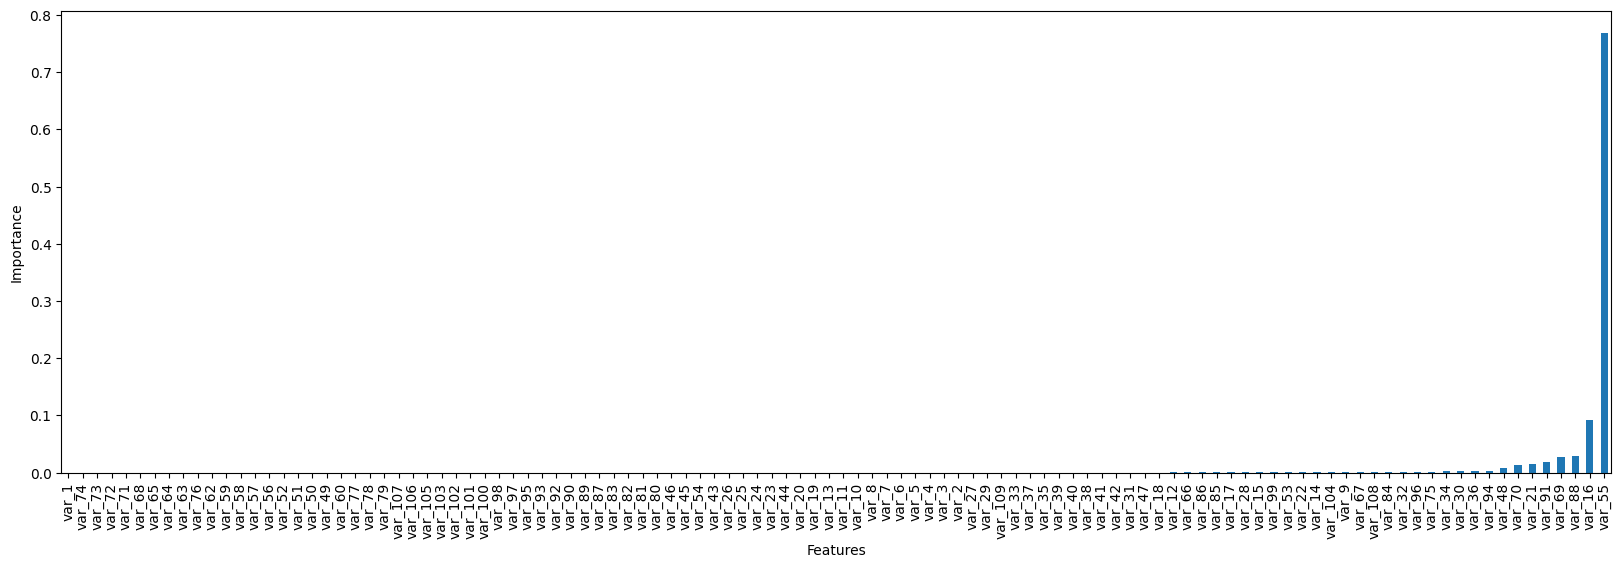

In [9]:
# bước thứ hai là độ quan trọng của
# từng đặc trưng và xếp theo thứ tự từ ít quan trọng nhất tới
# quan trọng nhất

# lấy được tên đặc trưng và độ quan trọng
## Yêu cầu 13:
## VIẾT CODE Ở ĐÂY:
features = pd.Series(model_full.feature_importances_)
features.index = X_train.columns

# sắp xếp các đặc trưng theo độ quan trọng
features.sort_values(ascending=True, inplace=True)

# vẽ biểu đồ
features.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

<details><summary> Gợi ý </summary>

Sử dụng ```feature_importances_```

</details>

In [10]:
# tạo danh sách các đặc trưng đã sắp xếp
features = list(features.index)
features

['var_1',
 'var_74',
 'var_73',
 'var_72',
 'var_71',
 'var_68',
 'var_65',
 'var_64',
 'var_63',
 'var_76',
 'var_62',
 'var_59',
 'var_58',
 'var_57',
 'var_56',
 'var_52',
 'var_51',
 'var_50',
 'var_49',
 'var_60',
 'var_77',
 'var_78',
 'var_79',
 'var_107',
 'var_106',
 'var_105',
 'var_103',
 'var_102',
 'var_101',
 'var_100',
 'var_98',
 'var_97',
 'var_95',
 'var_93',
 'var_92',
 'var_90',
 'var_89',
 'var_87',
 'var_83',
 'var_82',
 'var_81',
 'var_80',
 'var_46',
 'var_45',
 'var_54',
 'var_43',
 'var_26',
 'var_25',
 'var_24',
 'var_23',
 'var_44',
 'var_20',
 'var_19',
 'var_13',
 'var_11',
 'var_10',
 'var_8',
 'var_7',
 'var_6',
 'var_5',
 'var_4',
 'var_3',
 'var_2',
 'var_27',
 'var_29',
 'var_109',
 'var_33',
 'var_37',
 'var_35',
 'var_39',
 'var_40',
 'var_38',
 'var_41',
 'var_42',
 'var_31',
 'var_47',
 'var_18',
 'var_12',
 'var_66',
 'var_86',
 'var_85',
 'var_17',
 'var_28',
 'var_15',
 'var_99',
 'var_53',
 'var_22',
 'var_14',
 'var_104',
 'var_9',
 'var_67',

### Lựa chọn đặc trưng

In [14]:
# bước cuối cùng là loại lần lượt
# tất cả các đặc trưng, từ ít quan trọng nhất tới quan trọng nhất
# và xây dựng mô hình ở từng lượt.

# sau khi đã xây dựng mô hình, tính roc-auc mới

# nếu roc-auc mới nhỏ hơn roc-auc ban đầu
# (với tất cả đặc trưng) thì đặc trưng bị loại
# quan trọng, chúng ta cần giữ nó lại.
# nếu không, hãy loại bỏ nó

# loại đặc trưng đệ quy:

# trước tiên, chúng ta tùy ý thiết lập mức giảm trong roc-auc
# nếu mức giảm nằm dưới ngưỡng này,
# đặc trưng sẽ bị loại
tol = 0.0005

print('doing recursive feature elimination')

# hãy khởi tạo một danh sách thu thập
# các đặc trưng nên loại
features_to_remove = []

# cài đặt bộ đếm để biết vòng lặp ở đâu
count = 1

# giờ chúng ta lặp qua toàn bộ các đặc trưng, theo độ quan trọng:
# nhớ rằng các đặc trưng trong danh sách này được sắp xếp theo
# độ quan trọng
for feature in features:
    
    print()
    print('testing feature: ', feature, count, ' out of ', len(features))
    count = count + 1

    # khởi tạo mô hình
    model_int = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

    # khớp mô hình với tất cả các biến, trừ đặc trưng được đánh giá
    # cũng như tất cả các các đối tượng được coi là bị loại
    
    # features_to_remove sẽ rỗng ở các lượt đầu tiên
    # nhưng sẽ có các đặc trưng khi tiến hành vòng lặp
    model_int.fit(
        X_train.drop(features_to_remove + [feature], axis=1), y_train)

    # đưa ra dự đoán, sử dụng tập kiểm tra
    y_pred_test = model_int.predict_proba(
        X_test.drop(features_to_remove + [feature], axis=1))[:, 1]

    # tính toán roc-auc mới
    roc_int = roc_auc_score(y_test, y_pred_test)
    print('New Test ROC AUC={}'.format((roc_int)))

    # in ra roc-auc ban đầu với tất cả các đặc trưng
    print('Full dataset ROC AUC={}'.format((roc_full)))

    # xác định lượng giảm trong roc-auc
    diff_roc = roc_full - roc_int

    # so sánh lượng giảm trong roc-auc với dung sai
    # chúng ta đã thiết lập trước đó
    if diff_roc >= tol:
        print('Drop in ROC AUC={}'.format(diff_roc))
        print('keep: ', feature)
        print
    else:
        print('Drop in ROC AUC={}'.format(diff_roc))
        print('remove: ', feature)
        print
        # nếu lượng giảm trong roc-auc nhỏ và chúng ta loại đặc trưng,
        # cần đặt roc-auc mới dựa trên 
        # các đặc trưng còn lại
        roc_full = roc_int
        
        # và thêm các đặc trưng cần loại vào danh sách thu thập
        ## Yêu cầu 14:
        ## VIẾT CODE Ở ĐÂY:
        features_to_remove.append(roc_full)

# vòng lặp giờ đã hoàn thành, hãy đánh giá toàn bộ đặc trưng
print('DONE!!')
## Yêu cầu 15:
## VIẾT CODE Ở ĐÂY:
print('total features to remove: ', len(features_to_remove))

# xác định các đặc trưng cần giữ (các đặc trưng mà chúng ta sẽ không loại)
features_to_keep = [x for x in features if x not in features_to_remove]
print('total features to keep: ', len(features_to_keep))

# Hãy chờ một lúc, điều này tốn chút thời gian!

doing recursive feature elimination

testing feature:  var_1 1  out of  108


KeyError: "['var_1'] not found in axis"

In [ ]:
#  để so sánh, chúng ta sẽ xây dựng một mô hình chỉ với các đặc trưng đã chọn

model_final = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

# khớp mô hình với các đặc trưng đã chọn
model_final.fit(X_train[features_to_keep], y_train)

# đưa ra dự đoán
## Yêu cầu 16:
## VIẾT CODE Ở ĐÂY:
y_pred_test = model_final.predict_proba(X_test[features_to_keep])[:, 1]

# tính roc-auc
roc_final = roc_auc_score(y_test, y_pred_test)
print('Test selected features ROC AUC=%f' % (roc_final))

<details><summary> Gợi ý </summary>

Sử dụng ```predict_proba()```

</details>

Như các bạn thấy, mô hình Gradient Boosting với 12 đặc trưng cho thấy chất lượng tương tự với mô hình được xây với tập dữ liệu đầy đủ (cuộn lên trên để tìm giá trị này, chúng ta đã tính một vài cell trước đó).

**Bài tập:**
Hãy thử các giá trị dung sai khác. Thử với các ngưỡng nhỏ hơn hoặc lớn hơn để hiểu được tác động của điều này tới số lượng các đặc trưng được chọn.

## Phương pháp lai hóa: Loại bỏ đặc trưng đệ quy

Phương pháp này gồm các bước sau:

1) Xếp hạng các đặc trưng theo mức độ quan trọng lấy từ thuật toán học máy: có thể là độ quan trọng của cây hoặc các hệ số thu được từ mô hình tuyến tính.

2) Loại bỏ đặc trưng ít quan trọng nhất và xây dựng thuật toán học máy với các đặc trưng còn lại.

3) Tính toán số liệu chất lượng được chọn: roc-auc, mse, rmse, accuracy,...

4) Nếu chỉ số giảm nhiều hơn một ngưỡng được thiết lập tùy ý thì đặc trưng đó quan trọng và cần được giữ lại. Nếu không, chúng ta có thể loại đặc trưng đó.

5) Lặp lại các bước 2-4 cho đến khi đánh giá hết tất cả các đặc trưng.


Phương pháp này được gọi là lai hóa do:

- nó lấy độ quan trọng từ thuật toán học máy như các phương pháp nhúng 
- nó xây dựng một vài mô hình như các phương pháp gói.

Phương pháp này nhanh hơn so với các phương pháp gói và thường tốt hơn các phương pháp nhúng. Thực tế, nó hoạt động rất tốt.

Cần lưu ý là lượng giảm chất lượng tối thiểu quyết định liệu một đặc trưng có nên giữ lại hay không được thiết lập tùy ý. Lượng giảm càng nhỏ thì càng có nhiều đặc trưng được chọn và ngược lại.

Chúng ta sẽ minh họa cách lựa chọn đặc trưng sử dụng phương thức lai hóa trong bài toán phân loại và hồi quy.

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, r2_score

## Phân loại

In [ ]:
# load tập dữ liệu
######## Bài lab khong thấy lin tải dataset_1.csv nên sẽ thay vào dataset_2.csv sẽ có một chút lỗi kiểu dữ liệu
data = pd.read_csv('dataset_1.csv')
data.shape

In [ ]:
data.head()

**Quan trọng**

Trong tất cả các quy trình lựa chọn đặc trưng, chỉ nên chọn các đặc trưng bằng cách kiểm tra tập huấn luyện, điều này giúp tránh overfit.

In [ ]:
# tách thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

### Loại các đặc trưng không đổi và gần như không đổi

In [ ]:
# để tăng tốc độ, hãy loại các đặc trưng không đổi, gần như không đổi và trùng lặp

quasi_constant_feat = []

# lặp qua từng đặc trưng
for feature in X_train.columns:

    # tìm các giá trị nổi bật, là các giá trị
    # có ở hầu hết các quan sát
    predominant = (X_train[feature].value_counts() / np.float(
        len(X_train))).sort_values(ascending=False).values[0]

    # đánh giá đặc trưng nổi bật: có phải hơn 99% các quan sát
    # hiển thị 1 giá trị?
    if predominant > 0.998:
        
        # nếu đúng, hãy thêm biến vào danh sách
        quasi_constant_feat.append(feature)

## Yêu cầu 20:
## VIẾT CODE Ở ĐÂY:
X_train.drop(labels=quasi_constant_feat, axis=1, inplace=True)
X_test.drop(labels=quasi_constant_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

<details><summary> Gợi ý </summary>

Sử dụng ```quasi_constant_feat```

</details>

### Loại các đặc trưng trùng lặp

In [ ]:
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    if i % 10 == 0:  # điều này giúp chúng ta hiểu vòng lặp diễn ra như thế nào
        print(i)

    col_1 = X_train.columns[i]

    for col_2 in X_train.columns[i + 1:]:
        ## Yêu cầu 21:
        ## VIẾT CODE Ở ĐÂY:
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_1)
            
len(duplicated_feat)

In [12]:
# loại các đặc trưng trùng lặp
## Yêu cầu 22:
## VIẾT CODE Ở ĐÂY:
X_train.drop(labels=duplicated_feat, axis=1, inplace=True)
X_test.drop(labels=duplicated_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((35000, 108), (15000, 108))

<details><summary> Gợi ý </summary>

Sử dụng ```duplicated_feat```

</details>

### Huấn luyện mô hình học máy với toàn bộ các đặc trưng

In [ ]:
# bước đầu tiên của quy trình này là xây dựng
# thuật toán học máy sử dụng tất cả các đặc trưng hiện có
# sau đó xác định độ quan trọng của các đặc trưng
# theo thuật toán

# xây dựng mô hình ban đầu sử dụng tất cả các đặc trưng
model_full = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

model_full.fit(X_train, y_train)

# tính roc-auc trong tập kiểm tra
y_pred_test = model_full.predict_proba(X_test)[:, 1]
roc_full = roc_auc_score(y_test, y_pred_test)

print('Test ROC AUC=%f' % (roc_full))

### Xếp hạng đặc trưng theo độ quan trọng

In [ ]:
# bước thứ hai là độ quan trọng của
# từng đặc trưng theo thứ tự từ ít quan trọng nhất tới
# quan trọng nhất

# lấy được tên đặc trưng và độ quan trọng
features = pd.Series(model_full.feature_importances_)
features.index = X_train.columns

# sắp xếp các đặc trưng theo độ quan trọng
features.sort_values(ascending=False, inplace=True)

# vẽ biểu đồ
features.plot.bar(figsize=(20,6))
plt.ylabel('Importance')
plt.xlabel('Feature')

In [ ]:
# tạo danh sách các đặc trưng đã sắp xếp
features = list(features.index)
features

### Xây dựng mô hình học máy với 1 đặc trưng

In [ ]:
# tiếp theo, chúng ta cần xây dựng mô hình học máy 
# chỉ sử dụng đặc trưng quan trọng nhất

# xây dựng mô hình ban đầu với tất cả các đặc trưng
model_one_feature = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

# chỉ huấn luyện với đặc trưng quan trọng nhất
model_one_feature.fit(X_train[features[0]].to_frame(), y_train)

# tính roc-auc trong tập kiểm tra
y_pred_test = model_one_feature.predict_proba(X_test[features[0]].to_frame())[:, 1]

roc_first = roc_auc_score(y_test, y_pred_test)

print('Test one feature xgb ROC AUC=%f' % (roc_first))

### Lựa chọn đặc trưng

In [ ]:
# bước cuối cùng là lần lượt thêm một đặc trưng
# từ quan trọng nhất tới ít quan trọng nhất, xây dựng mô hình
# và xác định chất lượng

# sau khi đã xây dựng mô hình, tính roc-auc mới
# nếu roc-auc mới lớn hơn roc-auc ban đầu
# (với 1 đặc trưng) thì đặc trưng được thêm 
# quan trọng, chúng ta cần giữ nó lại.
# nếu không, hãy loại bỏ nó

# loại bỏ đặc trưng đệ quy:

# trước tiên chúng ta đặt tùy ý mức tăng trong roc-auc
# nếu mức tăng vượt ngưỡng này,
# thì giữ đặc trưng lại
tol = 0.0001

print('doing recursive feature addition')

# hãy khởi tạo một danh sách thu thập
# các đặc trưng nên giữ lại
features_to_keep = [features[0]]

# đặt bộ đếm để biết đặc trưng nào đang được đánh giá
count = 1

# giờ chúng ta lặp qua toàn bộ các đặc trưng, theo độ quan trọng:
# nhớ rằng các đặc trưng trong danh sách được sắp xếp
# theo độ quan trọng
for feature in features[1:]:
    print()
    print('testing feature: ', feature, count, ' out of ', len(features))
    count = count + 1

    # khởi tạo mô hình
    model_int = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

    # khớp mô hình với các đặc trưng đã chọn
    # và đặc trưng cần đánh giá
    model_int.fit(
        X_train[features_to_keep + [feature] ], y_train)

    # đưa ra dự đoán trên tập kiểm tra
    ## Yêu cầu 23:
    ## VIẾT CODE Ở ĐÂY:
    y_pred_test = model_int.predict_proba(
        X_test[features_to_keep + [feature] ])[:, 1]

    # tính toán roc-auc mới
    roc_int = roc_auc_score(y_test, y_pred_test)
    print('New Test ROC AUC={}'.format((roc_int)))

    # in ra roc-auc ban đầu với một đặc trưng
    print('Previous round Test ROC AUC={}'.format((roc_first)))

    # xác định mức tăng trong roc-auc
    diff_roc = roc_int - roc_first

    # so sánh mức tăng trong roc-auc với dung sai
    # chúng ta đã thiết lập trước đó
    if diff_roc >= tol:
        print('Increase in ROC AUC={}'.format(diff_roc))
        print('keep: ', feature)
        print
        # nếu mức tăng trong roc lớn hơn ngưỡng
        # chúng ta giữ lại đặc trưng và điều chỉnh lại roc-auc cho giá trị mới
        # xem xét đặc trưng đã thêm
        roc_first = roc_int
        
        # và thêm đặc trưng cần giữ lại vào danh sách
        features_to_keep.append(feature)
    else:
        # bỏ qua đặc trưng
        print('Increase in ROC AUC={}'.format(diff_roc))
        print('remove: ', feature)
        print

# vòng lặp giờ đã hoàn thành, hãy đánh giá toàn bộ đặc trưng
print('DONE!!')
print('total features to keep: ', len(features_to_keep))

<details><summary> Gợi ý </summary>

Sử dụng ```features_to_keep```

</details>

In [ ]:
# cuối cùng, hãy kiểm tra chất lượng của mô hình đã xây sử dụng đặc trưng đã chọn
# so với mô hình đầy đủ

# xây dựng mô hình đầu tiên
model_final = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

# khớp mô hình với các đặc trưng đã chọn
model_final.fit(X_train[features_to_keep], y_train)

# đưa ra dự đoán
y_pred_test = model_final.predict_proba(X_test[features_to_keep])[:, 1]

# tính roc-auc
roc_final = roc_auc_score(y_test, y_pred_test)
print('Test selected features ROC AUC=%f' % (roc_final))

Như các bạn thấy, mô hình Gradient Boosting với 15 đặc trưng cho thấy chất lượng tương tự với mô hình được xây với tập dữ liệu đầy đủ (cuộn lên trên để tìm giá trị này, chúng ta đã tính một vài cell trước đó).

**Bài tập:** Hãy thử các giá trị dung sai khác. Thử với các ngưỡng nhỏ hơn hoặc lớn hơn để hiểu được tác động của điều này tới số lượng các đặc trưng được chọn.